<a href="https://colab.research.google.com/github/Ul-tima/CommonLit/blob/main/CommonLitNote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Connect to Kaggle and load dataset to Google Drive
2. Install libaries
3. Create pretrained Roberta model with additional layers
4. Read train data. 
5. For training model I used only encoded excerpt feature
6. Save best model for futher work.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

%cd /content/gdrive/MyDrive/comlib/

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/comlib/"

Mounted at /content/gdrive
/content/gdrive/MyDrive/comlib


In [2]:
#Add kaggle.json to /content/gdrive/MyDrive/comlib/

#!pip install kaggle
#! kaggle competitions download -c commonlitreadabilityprize
#!unzip \*.zip  && rm *.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/1.13M [00:00<?, ?B/s]
100% 1.13M/1.13M [00:00<00:00, 25.8MB/s]
Archive:  commonlitreadabilityprize.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 27.0 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 6.6 MB 53.5 MB/s 


In [16]:
import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
from tensorflow.keras.metrics import RootMeanSquaredError

class CustomModel:
    def __init__(self):
        self.model_checkpoint ="roberta-base"
        self.tokenizer = RobertaTokenizer.from_pretrained(self.model_checkpoint)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=6e-6)
        self.pretrained_model = TFRobertaModel.from_pretrained(self.model_checkpoint)

    def encode(self, text, max_length=60):
        input_ids = []
        attention_masks = []

        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            pad_to_max_length=True,
            max_length=max_length,
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        return np.array(input_ids), np.array(attention_masks)

    def encode_series(self, series, max_length=60) :
          input_ids = []
          attention_masks = []

          for i in range(len(series)):
              encoded = self.tokenizer.encode_plus(
                series[i],
                add_special_tokens=True,
                pad_to_max_length=True,
                max_length = max_length,
                return_attention_mask=True,
              )
              
              input_ids.append(encoded['input_ids'])
              attention_masks.append(encoded['attention_mask'])
          return np.array(input_ids),np.array(attention_masks)


    def create_model(self):
        input_ids = tf.keras.Input(shape=(60,), dtype='int32')
        attention_masks = tf.keras.Input(shape=(60,), dtype='int32')
        
        output = self.pretrained_model.roberta([input_ids, attention_masks])[1]
        output = tf.keras.layers.Dense(16,activation='relu')(output)
        output = tf.keras.layers.Dropout(0.2)(output)
        output = tf.keras.layers.Dense(1)(output)
        self.model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

        self.model.compile(self.optimizer, loss='mean_squared_error', metrics=[RootMeanSquaredError()])

    def predict(self, text):
        text_encoded = self.encode(text)
        res = self.model.predict(text_encoded)
        return res[0][0]

    def load_from_weights(self, checkpoint_path):
        self.create_model()
        self.model.load_weights(checkpoint_path)

    def load_saved(self, checkpoint_path): 
        self.model =  tf.keras.models.load_model(checkpoint_path)


In [20]:
import pandas as pd

base_model = CustomModel()

train = pd.read_csv('train.csv')
train_input_ids,train_attention_masks = base_model.encode_series(train.excerpt)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting

In [7]:
checkpoint_path = 'saved'


# Create a callback that saves the best model
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True,
    verbose=1,
)

In [8]:
mod = base_model.create_model()
history = mod.fit(
  [train_input_ids, train_attention_masks],
  train.target,
  validation_split=0.3, 
  epochs=2, 
  batch_size=100,
  callbacks=[cp_callback]
)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/2
20/20 [==============================] - ETA: 0s - loss: 1.5652 - root_mean_squared_error: 1.2511  
Epoch 1: val_root_mean_squared_error improved from inf to 0.98965, saving model to saved


20/20 [==============================] - 1642s 81s/step - loss: 1.5652 - root_mean_squared_error: 1.2511 - val_loss: 0.9794 - val_root_mean_squared_error: 0.9897
Epoch 2/2
20/20 [==============================] - ETA: 0s - loss: 1.1532 - root_mean_squared_error: 1.0739  
Epoch 2: val_root_mean_squared_error improved from 0.98965 to 0.91298, saving model to saved


20/20 [==============================] - 1609s 80s/step - loss: 1.1532 - root_mean_squared_error: 1.0739 - val_loss: 0.8335 - val_root_mean_squared_error: 0.9130


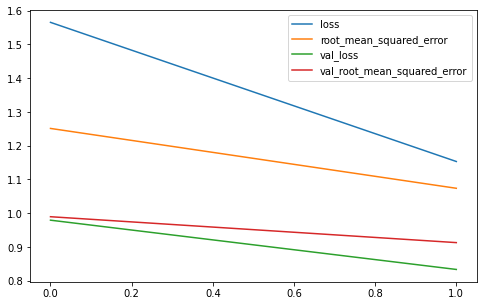

In [9]:
pd.DataFrame(history.history).plot(figsize=(8,5))

Reload saved model

In [17]:
import tensorflow as tf

checkpoint_path = 'saved'
trained = CustomModel()
trained.load_saved(checkpoint_path)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [21]:
trained.predict(train.excerpt[10])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


-1.0227587


## API server for the trained model

For running Fast Api from Colab we will use ngrok lib to export a port as an external url.

Pydantic forces to declare in advance the input format with constraint that "text" field should at least have 1 character.

Trained model will be downloaded from saved weight stored on Google Drive disk.

Example of post request
```
curl --location --request POST 'http://2014-35-197-8-74.ngrok.io/scoring' \
--header 'Content-Type: application/json' \
--data-raw '{
    "text" : "A grasshopper spent the summer hopping about in the sun and singing to his heart's content"
}'
```


Result
```
{
    "score": -0.7847004532814026
}
```


In [24]:
!pip install fastapi nest-asyncio pyngrok uvicorn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 745 kB 57.2 MB/s 
     |████████████████████████████████| 57 kB 5.1 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 80 kB 9.6 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=d5bd32e1d392d491a5a8cd195692a988121cf66b46d567a8717a409b287642a7
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [25]:
from fastapi import FastAPI
from pydantic import BaseModel, constr


app = FastAPI()

class UserRequestIn(BaseModel):
    text: constr(min_length=1)

@app.post("/scoring")
def score_text(user_request_in: UserRequestIn):
    return {
        "score": float(trained.predict(user_request_in.text))
    }

import nest_asyncio
from pyngrok import ngrok
import uvicorn

tunnels = ngrok.get_tunnels()
if not tunnels:
  ngrok_tunnel = ngrok.connect(8000)
else:
  ngrok_tunnel = tunnels[0]

print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

INFO:     Started server process [59]
INFO:uvicorn.error:Started server process [59]
INFO:     Waiting for application startup.
INFO:uvicorn.error:Waiting for application startup.
INFO:     Application startup complete.
INFO:uvicorn.error:Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:uvicorn.error:Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Public URL: http://3105-35-236-231-69.ngrok.io
INFO:     54.86.50.139:0 - "POST /scoring HTTP/1.1" 422 Unprocessable Entity


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


INFO:     54.86.50.139:0 - "POST /scoring HTTP/1.1" 200 OK
INFO:     54.86.50.139:0 - "POST /scoring HTTP/1.1" 422 Unprocessable Entity
INFO:     54.86.50.139:0 - "POST /scoring HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:uvicorn.error:Shutting down
INFO:     Waiting for application shutdown.
INFO:uvicorn.error:Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:uvicorn.error:Application shutdown complete.
INFO:     Finished server process [59]
INFO:uvicorn.error:Finished server process [59]
